In [1]:
from modules.Utils.utils import loadFromDB, strategyTester
from modules.Utils.indicators import computeSuperTrend, addIndicators, computeLaggingLinearRegression, computeTrixIndicator, generateDatesFeatures
import pandas as pd
import numpy as np
from ta.trend import ema_indicator

from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

# Stochastic approch

In [109]:
SYMBOL= 'KDA'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df['EMA'] = ema_indicator(df.Close, 20)

metric = 'EMA'
#df = df[[metric]]
df.dropna(inplace=True)
df = df.iloc[-2000:]
print(df.shape)
df.head()

(2000, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA
Date,,,,,,,
2022-06-06 17:00:00,2.0852,2.0858,2.0600,2.0762,134500.631376,1654527600,2.067678
2022-06-06 18:00:00,2.0759,2.0936,2.0100,2.0379,272353.435755,1654531200,2.064842
2022-06-06 19:00:00,2.0397,2.0470,2.0060,2.0441,67684.503014,1654534800,2.062866
2022-06-06 20:00:00,2.0409,2.0600,2.0206,2.0525,116322.155008,1654538400,2.061879
2022-06-06 21:00:00,2.0537,2.0602,2.0335,2.0497,61193.231276,1654542000,2.060719


In [119]:
a = list(df[metric])
b = df[metric].diff().fillna(0)

df['stepsize']=b


c=list(df.stepsize.abs())

import statistics as s
harmean=[0,0]
i=1
j=2
while j<len(c):
  harsteps=s.harmonic_mean(c[i:j])
  harmean.append(harsteps)
  j+=1
  

df['harmean of magnitude'] = harmean

j=1
countofup=[0,0]
probabilityofup = [0,0]

while j<len(b)-1:
  if b[j]<0:
    countofup.append(0)
    a = sum(countofup)/j
    probabilityofup.append(a)
    j+=1
  else: 
    countofup.append(1)
    p = sum(countofup)/j
    probabilityofup.append(p)
    j+=1
    
df['probabilityofup'] = probabilityofup

a=list(df[metric])
b=list(df['harmean of magnitude'])
c=list(df['probabilityofup'])

import random

pred = [0,0]
i=1

while i<len(df)-1:
  if random.uniform(0,1)>c[i]:
    prediction = a[i]+(b[i+1]*-1)
    pred.append(prediction)
    i+=1
  else:
    prediction = a[i]+(b[i+1]*1)
    pred.append(prediction)
    i+=1
    
df['prediction']=pred
df= df.iloc[4:]
#df[f'{metric}_EMA'] = df[metric].rolling(5).mean()
#df[f'prediction_EMA'] = df['prediction'].rolling(5).mean()
#df.dropna(inplace=True)


In [115]:
#def computePrediction(df):
#    if random.uniform(0,1)>df['probabilityofup'].iloc[-2]:
#        prediction = df[metric].iloc[-2]+(df['harmean of magnitude'].iloc[-1]*-1)
#    else:
#        prediction = df[metric].iloc[-2]+(df['harmean of magnitude'].iloc[-1]*1)
#        
#    a = list(df[metric])
#    last_stepsize = df[metric].diff().iloc[-1]
#    
#    df['stepsize']=b

In [116]:
p = figure(title=f"Prediction on {metric}", x_axis_label='time', y_axis_label='value ($)',x_axis_type='datetime',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
    ("Date", "$x{%F}"),
], formatters={
        '$x': 'datetime',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(df.index, df[metric], legend_label="real data", line_width=2, )
p.line(df.index, df['prediction'], legend_label="prediction data", line_width=2, color='orange')
p.legend.location = "top_left"
show(p)

Period : [2022-06-07 07:00:00] -> [2022-08-29 00:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 477.5 $
Performance vs US Dollar : -52.25 %
Buy and Hold Performence : -17.93 %
Performance vs Buy and Hold : 191.4 %
Best trade : +8.8 %, the 2022-08-01 13:00:00
Worst trade : -7.54 %, the 2022-06-14 00:00:00
Worst drawBack : -54.0 %
Total fees :  94.85 $

----- Trades Informations -----
Total trades on period : 114
Number of positive trades : 31
Number of negative trades :  83
Trades win rate ratio : 27.19 %
Average trades performance : -0.55 %
Average positive trades : 2.21 %
Average negative trades : -1.58 %

----- Plot -----


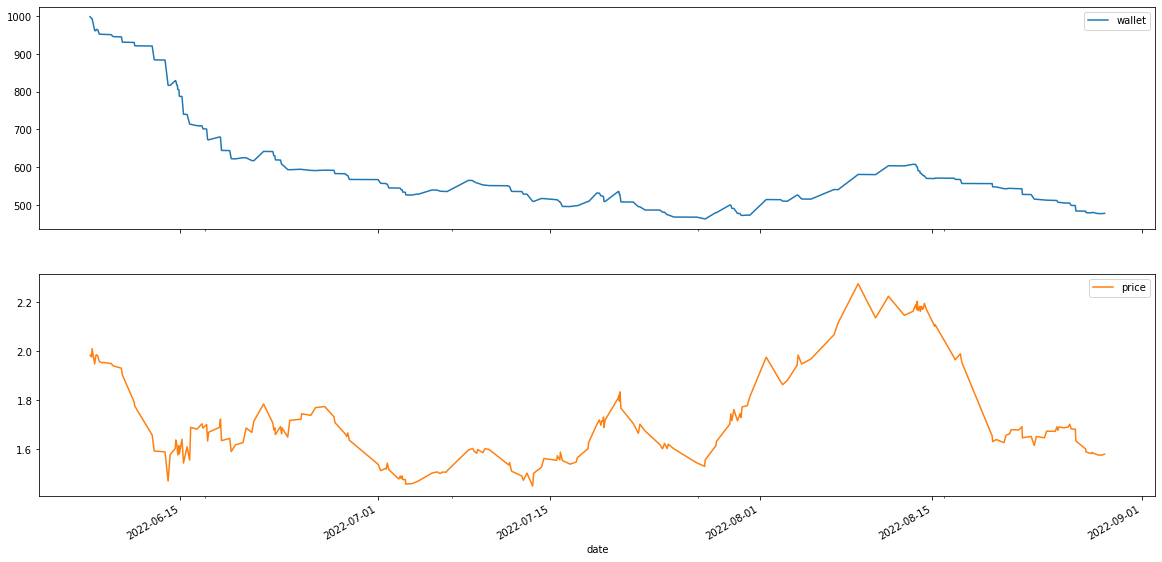

In [117]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row[metric] > row['prediction'] ) else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row[metric] < row['prediction'] )  else False

strategyTester(df,buyCondition,sellCondition,equity=1000,)

# Linear regression

In [205]:
SYMBOL= 'ETH'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df['EMA'] = ema_indicator(df.Close, 10)

metric = 'EMA'
#df = df[[metric]]
df.dropna(inplace=True)
#df = df.iloc[-2000:]
print(df.shape)
df.head()

(21794, 7)


,Open,High,Low,Close,Volume,Timestamp,EMA
Date,,,,,,,
2020-01-01 10:00:00,130.34,130.61,130.15,130.16,225.292253,1577869200,130.081010
2020-01-01 11:00:00,130.15,130.77,130.14,130.64,142.823678,1577872800,130.182645
2020-01-01 12:00:00,130.65,131.73,130.60,130.74,380.248744,1577876400,130.283982
2020-01-01 13:00:00,130.73,131.54,130.73,131.53,213.939938,1577880000,130.510531
2020-01-01 14:00:00,131.53,131.90,131.30,131.61,326.729923,1577883600,130.710434


In [206]:
a = list(df[metric])
b = df[metric].diff().fillna(0)

df['stepsize']=b


c=list(df.stepsize.abs())

import statistics as s
harmean=[0,0]
i=1
j=2
while j<len(c):
  harsteps=s.harmonic_mean(c[i:j])
  harmean.append(harsteps)
  j+=1
  

df['harmean of magnitude'] = harmean

j=1
countofup=[0,0]
probabilityofup = [0,0]

while j<len(b)-1:
  if b[j]<0:
    countofup.append(0)
    a = sum(countofup)/j
    probabilityofup.append(a)
    j+=1
  else: 
    countofup.append(1)
    p = sum(countofup)/j
    probabilityofup.append(p)
    j+=1
    
df['probabilityofup'] = probabilityofup

a=list(df[metric])
b=list(df['harmean of magnitude'])
c=list(df['probabilityofup'])

import random

pred = [0,0]
i=1

while i<len(df)-1:
  if random.uniform(0,1)>c[i]:
    prediction = a[i]+(b[i+1]*-1)
    pred.append(prediction)
    i+=1
  else:
    prediction = a[i]+(b[i+1]*1)
    pred.append(prediction)
    i+=1
    
df['prediction']=pred
df= df.iloc[4:]

In [209]:
offset = 10

X = df[['EMA','stepsize','harmean of magnitude','probabilityofup','prediction']].iloc[:-offset]
y = df[[metric]].iloc[offset:]

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Lasso, Ridge, SGDRegressor

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2,shuffle=False)

lr = ElasticNetCV()

lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.9962124673432458

In [211]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test.reshape(1,-1)[0], lr.predict(X_test).reshape(1,-1)[0])

33.24445969513353

In [212]:
p = figure(title=f"Prediction on {metric}", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'printf',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(X_test))), y_test.reshape(1,-1)[0], legend_label="real data", line_width=2, )
p.line(list(range(len(X_test))), lr.predict(X_test).reshape(1,-1)[0]-mean_absolute_error(y_test.reshape(1,-1)[0], lr.predict(X_test).reshape(1,-1)[0])/2, legend_label="prediction data", line_width=2, color='orange')
p.legend.location = "top_left"
show(p)

In [ ]:
lr.predict(X).reshape(1,-1)[0]

array([1.48927039, 1.47964868, 1.47091485, ..., 1.59925388, 1.59804814,
       1.59559203])

In [203]:

df['Pred_lr'] = np.nan 
df['Pred_lr'].iloc[:-offset] = lr.predict(X).reshape(1,-1)[0]-mean_absolute_error(y, lr.predict(X).reshape(1,-1)[0])/2

df = df.dropna()
df

,Open,High,Low,Close,Volume,Timestamp,EMA,stepsize,harmean of magnitude,probabilityofup,prediction,Pred_lr
Date,,,,,,,,,,,,
2020-01-02 00:00:00,130.33,130.80,129.80,130.68,450.121049,1577919600,131.122272,0.35,0.369688,0.333333,129.960312,116.540817
2020-01-02 01:00:00,130.70,130.76,130.33,130.64,270.285698,1577923200,131.076341,-0.04,0.364562,0.500000,131.044562,116.791231
2020-01-02 02:00:00,130.64,130.64,130.13,130.21,358.821278,1577926800,130.993832,-0.43,0.138997,0.400000,130.778997,116.480830
2020-01-02 03:00:00,130.20,130.21,129.01,129.70,639.394988,1577930400,130.870610,-0.51,0.156668,0.333333,130.366668,116.081890
2020-01-02 04:00:00,129.69,129.69,128.80,129.05,840.733235,1577934000,130.697219,-0.65,0.173877,0.285714,129.526123,115.488156
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-28 10:00:00,1496.99,1503.99,1488.60,1493.80,2422.583541,1661673600,1494.130549,-3.19,0.000000,0.511990,1496.990000,1477.227765
2022-08-28 11:00:00,1493.80,1494.20,1485.83,1490.26,1436.868264,1661677200,1493.761925,-3.54,0.000000,0.511967,1493.800000,1474.479842
2022-08-28 12:00:00,1490.26,1492.29,1482.30,1484.88,1694.430533,1661680800,1492.916027,-5.38,0.000000,0.511943,1490.260000,1470.580540


Period : [2020-01-02 00:00:00] -> [2022-08-28 14:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 364.23 $
Performance vs US Dollar : -63.58 %
Buy and Hold Performence : 1023.87 %
Performance vs Buy and Hold : -106.21 %
Best trade : +7.69 %, the 2022-05-11 15:00:00
Worst trade : -22.23 %, the 2022-01-20 16:00:00
Worst drawBack : -69.0 %
Total fees :  577.26 $

----- Trades Informations -----
Total trades on period : 559
Number of positive trades : 321
Number of negative trades :  238
Trades win rate ratio : 57.42 %
Average trades performance : -0.08 %
Average positive trades : 1.03 %
Average negative trades : -1.58 %

----- Plot -----


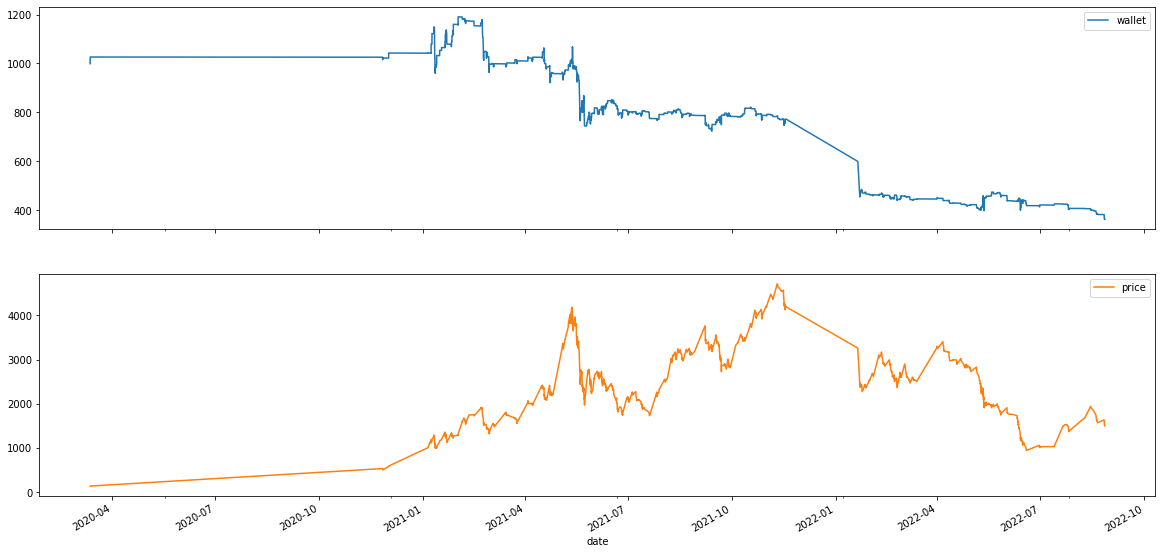

In [204]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred_lr']>row['Close']) else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred_lr']<row['Close'])else False

strategyTester(df,buyCondition,sellCondition,equity=1000,)

# LSTM

## Regression

In [14]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv').iloc[-13000:]
df = addIndicators(df)
df = computeLaggingLinearRegression(df, 'Close',20, False)

df = computeTrixIndicator(df, col='Close')
df.dropna(inplace=True)
# Technical indicators
from scipy.signal import savgol_filter

from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 30, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend

df['B_MLR_coefs_denoised'] = filterData(df['B_MLR_coefs'], method='savgol')
#df = df[[metric]]

#lags = 5; cols = []#

#for lag in range(1, lags + 1):
#    col = f'lag_{lag}'
#    df[col] = df['EMA20'].shift(lag)
    
df = generateDatesFeatures(df)
df.dropna(inplace=True)
print(df.columns)
print(df.shape)
df.head()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'B_MLR_coefs', 'B_MLR_coefs_diff', 'Trix',
       'Trix_histo', 'B_MLR_coefs_denoised', 'Day', 'Month', 'Year',
       'Day_week', 'Week', 'Hour', 'Day_sin', 'Day_cos', 'Year_sin',
       'Year_cos'],
      dtype='object')
(12723, 37)


,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Day,Month,Year,Day_week,Week,Hour,Day_sin,Day_cos,Year_sin,Year_cos
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-12 23:00:00,34729.3,35028.3,33359.5,33732.9,264.816639,1610488800,1668.8,34630.992778,35330.589613,36176.437743,...,12,1,2021,1,2,23,-2.588190e-01,0.965926,0.214908,0.976634
2021-01-13 00:00:00,33755.8,34130.3,33305.0,34063.5,421.565797,1610492400,825.3,34576.945846,35280.899825,36134.597392,...,13,1,2021,2,2,0,-1.263725e-11,1.000000,0.215608,0.976480
2021-01-13 01:00:00,34050.0,34050.1,32361.8,32508.1,532.980229,1610496000,1688.3,34379.912909,35172.162577,36062.785563,...,13,1,2021,2,2,1,2.588190e-01,0.965926,0.216308,0.976325
2021-01-13 02:00:00,32513.2,33256.0,32489.9,33131.0,397.818084,1610499600,766.1,34260.968822,35092.116985,36004.730403,...,13,1,2021,2,2,2,5.000000e-01,0.866025,0.217007,0.976170
2021-01-13 03:00:00,33125.8,33549.9,32563.7,33033.5,331.188474,1610503200,986.2,34144.067029,35011.386907,35945.894157,...,13,1,2021,2,2,3,7.071068e-01,0.707107,0.217707,0.976014


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
metric = 'B_MLR_coefs_denoised'
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'B_MLR_coefs', 'Trix',
       'Trix_histo', 'Day', 'Month', 'Year',
       'Day_week', 'Week', 'Hour', 'Day_sin', 'Day_cos', 'Year_sin',
       'Year_cos']

scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df[features])

scaler_labels = MinMaxScaler()
scaled_labels = scaler_labels.fit_transform(df[[metric]])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

select = SelectKBest(score_func=f_regression, k=6)
z = select.fit_transform(scaled_features,scaled_labels)
scaled_features=z
            


days_in_future=1
lag = 5

X = np.array([scaled_features[i-lag:i,:] for i in range(lag, len(scaled_features)-days_in_future)])
y = np.array([scaled_labels[i+days_in_future] for i in range(lag, len(scaled_features)-days_in_future)])
    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)


In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, InputLayer,Flatten, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

lstm_model=Sequential()
lstm_model.add(InputLayer((lag, X_train[0].shape[1])))
lstm_model.add(SimpleRNN(units=10,return_sequences=True,activation='relu'))
lstm_model.add(SimpleRNN(units=10,activation='relu'))
lstm_model.add(Flatten())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(5,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))

lstm_model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0005))
lstm_model.fit(X_train,
               y_train,
               epochs=20,
               batch_size=64,
               verbose=1,
               validation_split=0.2,
               callbacks=[early_stop],
               use_multiprocessing=True,shuffle=True)

Epoch 1/20
128/128 [==============================] - 5s 14ms/step - loss: 0.0357 - val_loss: 0.0039
Epoch 2/20
128/128 [==============================] - 1s 10ms/step - loss: 0.0166 - val_loss: 0.0042
Epoch 3/20
128/128 [==============================] - 1s 10ms/step - loss: 0.0106 - val_loss: 0.0042
Epoch 4/20
128/128 [==============================] - 1s 11ms/step - loss: 0.0077 - val_loss: 0.0045
Epoch 5/20
128/128 [==============================] - 1s 10ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 6/20
128/128 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 7/20
128/128 [==============================] - 2s 13ms/step - loss: 0.0054 - val_loss: 0.0050


In [17]:
p = figure(title=f"Prediction on {metric} ", x_axis_label='time', y_axis_label='value ($)',width=1500, height=600,)
# Add the HoverTool to the figure
p.add_tools(HoverTool(
    tooltips=[
    ("Price", "@y{0.00} $"),
], formatters={
        '$x': 'printf',
        '$y' : 'printf',
    },
    mode='vline'
))
p.line(list(range(len(X_test))), y_test.reshape(1,-1)[0], legend_label="real data", line_width=2, )
p.line(list(range(len(X_test))), lstm_model.predict(X_test).reshape(1,-1)[0], legend_label="prediction data", line_width=2, color='orange')
p.legend.location = "top_left"
show(p)

In [126]:
df['Pred'] = np.nan
df['Pred'].iloc[lag:-days_in_future] = scaler_labels.inverse_transform(lstm_model.predict(X)).reshape(1,-1)[0]

In [127]:
df['Pred_diff']=df['Pred'].diff(10)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Timestamp,EMA20,Return,EMA20_filtered,lag_1,lag_2,lag_3,lag_4,lag_5,Pred,Pred_diff
Date,,,,,,,,,,,,,,,,
2021-05-12 23:00:00,1.2948,1.2948,1.2841,1.2841,24101.813691,1620853200,1.372577,-0.008264,1.363200,1.381891,1.391058,1.400728,1.410646,1.420241,1.443369,-0.061213
2021-05-13 00:00:00,1.2837,1.2877,1.2673,1.2673,33661.649784,1620856800,1.362551,-0.013083,1.351962,1.372577,1.381891,1.391058,1.400728,1.410646,1.436007,-0.062445
2021-05-13 01:00:00,1.2684,1.2787,1.2617,1.2617,33669.419609,1620860400,1.352946,-0.004419,1.340526,1.362551,1.372577,1.381891,1.391058,1.400728,1.428894,-0.062737
2021-05-13 02:00:00,1.2617,1.2717,1.1784,1.2442,87090.987091,1620864000,1.342589,-0.013870,1.328957,1.352946,1.362551,1.372577,1.381891,1.391058,1.421790,-0.063514
2021-05-13 03:00:00,1.2480,1.2480,1.2200,1.2224,67028.741597,1620867600,1.331143,-0.017521,1.317351,1.342589,1.352946,1.362551,1.372577,1.381891,1.414351,-0.065669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-28 19:00:00,1.5761,1.6698,1.5748,1.6087,348609.466627,1661706000,1.581523,0.020684,1.584703,1.578662,1.578932,1.578093,1.579093,1.581039,1.564957,-0.004674
2022-08-28 20:00:00,1.6086,1.6197,1.6059,1.6142,82385.426649,1661709600,1.584635,0.003419,1.584866,1.581523,1.578662,1.578932,1.578093,1.579093,1.565610,-0.004379
2022-08-28 21:00:00,1.6133,1.6177,1.5831,1.5952,67315.156853,1661713200,1.585641,-0.011771,1.584980,1.584635,1.581523,1.578662,1.578932,1.578093,1.565648,-0.004779


Period : [2021-05-12 23:00:00] -> [2022-08-28 23:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 3533.19 $
Performance vs US Dollar : 253.32 %
Buy and Hold Performence : 24.04 %
Performance vs Buy and Hold : 953.73 %
Best trade : +155.15 %, the 2021-11-08 16:00:00
Worst trade : -15.49 %, the 2021-12-06 03:00:00
Worst drawBack : -84.0 %
Total fees :  1525.27 $

----- Trades Informations -----
Total trades on period : 228
Number of positive trades : 86
Number of negative trades :  142
Trades win rate ratio : 37.72 %
Average trades performance : 1.29 %
Average positive trades : 9.76 %
Average negative trades : -3.85 %

----- Plot -----


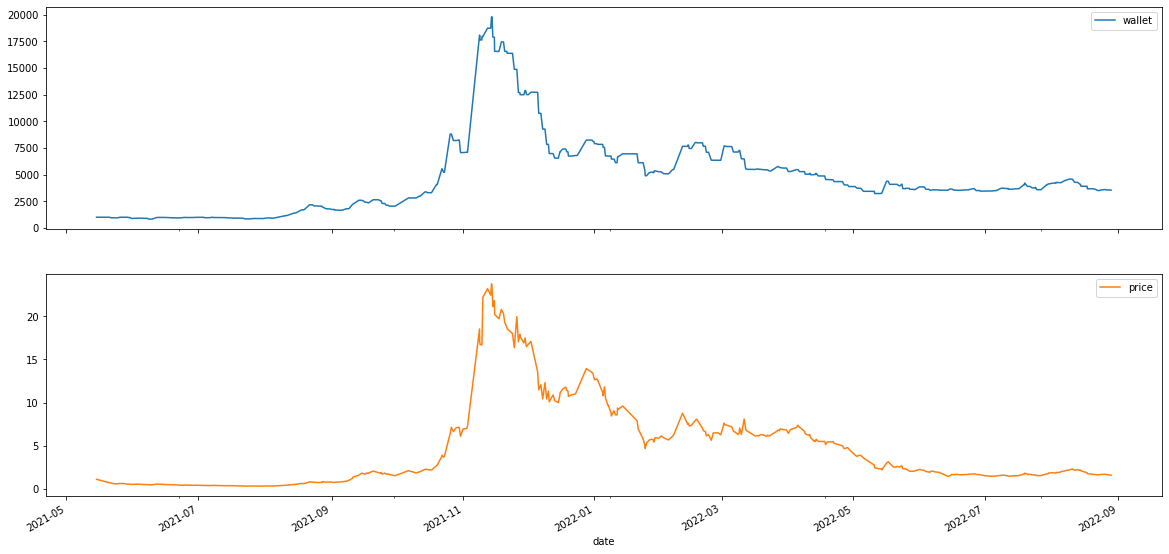

In [128]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred_diff']>0) else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred_diff']<0)else False

strategyTester(df,buyCondition,sellCondition,equity=1000,)

## Classification

In [183]:
SYMBOL= 'BTC'
df = loadFromDB(f'../backtest_tools/database/database/KuCoin/1h/{SYMBOL}-USDT.csv')
df = addIndicators(df)
df['EMA20']=ema_indicator(df.Close, 20)
df['Return'] = df.Close.pct_change()
metric = 'EMA20_filtered'
#df = df[[metric]]
df.dropna(inplace=True)

# Technical indicators
from scipy.signal import savgol_filter
from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 50, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend
    
df[f'EMA20_filtered'] = filterData(df['EMA20'].values) 

lags = 5; cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df[col] = df['EMA20'].shift(lag) 


df['EMA20_filtered_diff']  = df['EMA20_filtered'].diff(1)
df['EMA20_filtered_target'] = np.nan

df.loc[df['Return']>0,'EMA20_filtered_target']  =1
df.loc[df['Return']<0,'EMA20_filtered_target']  =0 
df.dropna(inplace=True)
print(df.shape)
print(df.columns)
df.head()

(21556, 31)
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Timestamp', 'High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM', 'Return', 'EMA20_filtered', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'EMA20_filtered_diff',
       'EMA20_filtered_target'],
      dtype='object')


,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,EVM,Return,EMA20_filtered,lag_1,lag_2,lag_3,lag_4,lag_5,EMA20_filtered_diff,EMA20_filtered_target
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-10 08:00:00,7749.2,7758.9,7730.4,7752.3,47.214818,1578639600,28.5,7819.852219,7897.575948,7848.226593,...,-5.402435e+08,0.000400,7833.922189,7826.962978,7835.148555,7843.964193,7848.949897,7852.628834,3.087413,1.0
2020-01-10 09:00:00,7751.5,7753.2,7689.0,7703.9,47.455725,1578643200,64.2,7808.809150,7889.980813,7845.368641,...,-3.185938e+09,-0.006243,7837.695248,7819.852219,7826.962978,7835.148555,7843.964193,7848.949897,3.773060,0.0
2020-01-10 10:00:00,7704.9,7754.2,7698.7,7722.2,45.650179,1578646800,55.5,7800.560660,7883.401173,7842.929658,...,6.504356e+08,0.002375,7842.293233,7808.809150,7819.852219,7826.962978,7835.148555,7843.964193,4.597985,1.0
2020-01-10 11:00:00,7722.2,7789.2,7682.0,7769.8,61.759250,1578650400,107.2,7797.631073,7878.946225,7841.481546,...,1.588232e+09,0.006164,7847.693568,7800.560660,7808.809150,7819.852219,7826.962978,7835.148555,5.400335,1.0
2020-01-10 12:00:00,7769.8,7850.0,7769.8,7843.0,110.398623,1578654000,80.2,7801.951923,7877.536569,7841.511614,...,5.397585e+09,0.009421,7853.779599,7797.631073,7800.560660,7808.809150,7819.852219,7826.962978,6.086031,1.0


In [185]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical

scaler_features = StandardScaler()
scaled_features = scaler_features.fit_transform(df[['High_Low_diff',
       'EMA20', 'EMA50', 'EMA100', 'EMA200', 'MACD', 'Stoch_RSI', 'Vortex',
       'Bollinger_low', 'Bollinger_high', 'ADX', 'ATR', 'CCI', 'OVB',
       'OVB_EMA200', 'EVM']])

scaled_labels = df[['EMA20_filtered_target']].values

days_in_future=1
lag = 15

X = np.array([scaled_features[i-lag:i,:] for i in range(lag, len(scaled_features)-days_in_future)])
y = to_categorical(np.array([scaled_labels[i+days_in_future] for i in range(lag, len(scaled_features)-days_in_future)]))
    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)


In [186]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, InputLayer,Flatten, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
from tensorflow.keras.utils import to_categorical

early_stop = EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=6, verbose=1, mode='auto',
    baseline=None, restore_best_weights=True)

lstm_model=Sequential()
lstm_model.add(InputLayer((lag, X_train[0].shape[1])))
lstm_model.add(SimpleRNN(units=50,return_sequences=True,activation='relu'))
lstm_model.add(SimpleRNN(units=20,activation='relu'))
lstm_model.add(Flatten())
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(5,activation='relu'))
lstm_model.add(Dense(2,activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0005),metrics=['accuracy'])

lstm_model.fit(X_train,
               y_train,
               epochs=20,
               batch_size=64,
               verbose=1,
               validation_split=0.2,
               callbacks=[early_stop],
               use_multiprocessing=True,shuffle=True)
lstm_model.evaluate(X_test,y_test,use_multiprocessing=True,verbose=1)

Epoch 1/20
216/216 [==============================] - 7s 20ms/step - loss: 0.6941 - accuracy: 0.5089 - val_loss: 0.6936 - val_accuracy: 0.5057
Epoch 2/20
216/216 [==============================] - 3s 16ms/step - loss: 0.6929 - accuracy: 0.5140 - val_loss: 0.6950 - val_accuracy: 0.5059
Epoch 3/20
216/216 [==============================] - 4s 17ms/step - loss: 0.6924 - accuracy: 0.5135 - val_loss: 0.6950 - val_accuracy: 0.5054
Epoch 4/20
216/216 [==============================] - 4s 17ms/step - loss: 0.6915 - accuracy: 0.5169 - val_loss: 0.6946 - val_accuracy: 0.5051
Epoch 5/20
216/216 [==============================] - 4s 18ms/step - loss: 0.6915 - accuracy: 0.5166 - val_loss: 0.6950 - val_accuracy: 0.5054
Epoch 6/20
216/216 [==============================] - 4s 18ms/step - loss: 0.6920 - accuracy: 0.5141 - val_loss: 0.6942 - val_accuracy: 0.5039
Epoch 7/20
216/216 [==============================] - 4s 18ms/step - loss: 0.6912 - accuracy: 0.5203 - val_loss: 0.6968 - val_accuracy: 0.4999

[0.6938175559043884, 0.49280408024787903]

In [187]:
df['Pred'] = np.nan
df['Pred'].iloc[lag:-days_in_future] = [pred.argmax() for pred in lstm_model.predict(X)]
df.head()

,Open,High,Low,Close,Volume,Timestamp,High_Low_diff,EMA20,EMA50,EMA100,...,Return,EMA20_filtered,lag_1,lag_2,lag_3,lag_4,lag_5,EMA20_filtered_diff,EMA20_filtered_target,Pred
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-10 08:00:00,7749.2,7758.9,7730.4,7752.3,47.214818,1578639600,28.5,7819.852219,7897.575948,7848.226593,...,0.000400,7833.922189,7826.962978,7835.148555,7843.964193,7848.949897,7852.628834,3.087413,1.0,NaN
2020-01-10 09:00:00,7751.5,7753.2,7689.0,7703.9,47.455725,1578643200,64.2,7808.809150,7889.980813,7845.368641,...,-0.006243,7837.695248,7819.852219,7826.962978,7835.148555,7843.964193,7848.949897,3.773060,0.0,NaN
2020-01-10 10:00:00,7704.9,7754.2,7698.7,7722.2,45.650179,1578646800,55.5,7800.560660,7883.401173,7842.929658,...,0.002375,7842.293233,7808.809150,7819.852219,7826.962978,7835.148555,7843.964193,4.597985,1.0,NaN
2020-01-10 11:00:00,7722.2,7789.2,7682.0,7769.8,61.759250,1578650400,107.2,7797.631073,7878.946225,7841.481546,...,0.006164,7847.693568,7800.560660,7808.809150,7819.852219,7826.962978,7835.148555,5.400335,1.0,NaN
2020-01-10 12:00:00,7769.8,7850.0,7769.8,7843.0,110.398623,1578654000,80.2,7801.951923,7877.536569,7841.511614,...,0.009421,7853.779599,7797.631073,7800.560660,7808.809150,7819.852219,7826.962978,6.086031,1.0,NaN


Period : [2020-01-10 23:00:00] -> [2022-08-28 23:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 5328.16 $
Performance vs US Dollar : 432.82 %
Buy and Hold Performence : 146.81 %
Performance vs Buy and Hold : 194.82 %
Best trade : +312.98 %, the 2021-01-10 04:00:00
Worst trade : -46.13 %, the 2022-01-21 23:00:00
Worst drawBack : -50.0 %
Total fees :  259.38 $

----- Trades Informations -----
Total trades on period : 34
Number of positive trades : 19
Number of negative trades :  15
Trades win rate ratio : 55.88 %
Average trades performance : 11.42 %
Average positive trades : 27.76 %
Average negative trades : -9.27 %

----- Plot -----


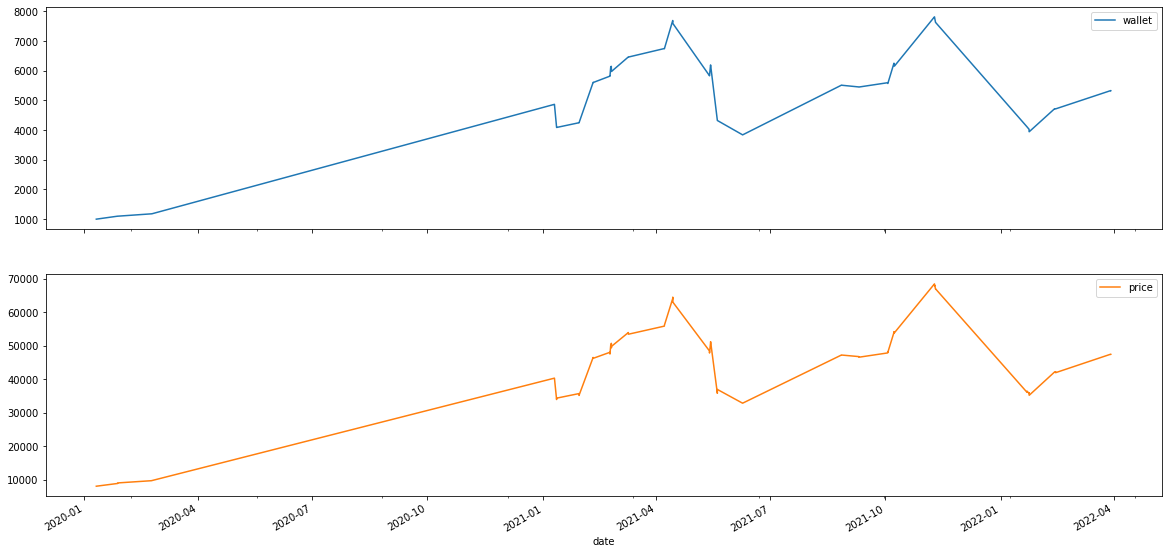

In [188]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred']==1) else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if (row['Pred']==0)else False

strategyTester(df.dropna(),buyCondition,sellCondition,equity=1000,)

# Extrem Machine Learning